This is an example notebook on how to contrain the registration in respect to specific tranformation parameters using `Scales`. The example involves an Euler Transform (=Rigid Transform) where the translation along one axis is constrained.

In [1]:
import itk
import numpy as np
import matplotlib.pyplot as plt

### Create a synthetic pair of images

In [2]:
fixed_image = np.zeros((100, 100), dtype=np.float32)
fixed_image[25:75, 25:75] = 1
fixed_image = itk.image_from_array(fixed_image)

In [3]:
translation = [20, -15]
transform = itk.Euler2DTransform.New()
transform.SetOffset(translation)
transform.SetAngleInDegrees(15)
transform.SetCenter([50, 50])

parameter_map = {
                 "Direction": ("1", "0", "0", "1"),
                 "Index": ("0", "0"),
                 "Origin": ("0", "0"),
                 "Size": ("100", "100"),
                 "Spacing": ("1", "1"),
                 "FinalBSplineInterpolationOrder": ("0")
                }

In [4]:
transform_parameter_object = itk.ParameterObject.New()
transform_parameter_object.AddParameterMap(parameter_map)

transformix_filter = itk.TransformixFilter.New(fixed_image)
transformix_filter.SetMovingImage(fixed_image)
transformix_filter.SetTransformParameterObject(transform_parameter_object)
transformix_filter.SetTransform(transform)
transformix_filter.Update()

moving_image = transformix_filter.GetOutput()

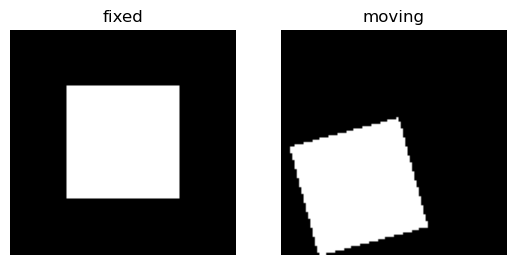

In [5]:
def show_images(images):
    labels = ['fixed', 'moving', 'registered']
    for i, image in enumerate(images):
        plt.subplot(1, len(images), i+1)
        plt.imshow(image, cmap='gray')
        plt.title(labels[i])
        plt.axis('off')
    plt.show()

show_images([fixed_image, moving_image])

### Registration 1: Unconstrained

This first registration is unconstrained, and serves the purpose of having a baseline to compare the contrained registration that follows.

In [6]:
rigid_parameter_object = itk.ParameterObject.New()
rigid_parameter_map = rigid_parameter_object.GetDefaultParameterMap('rigid')
rigid_parameter_map['FinalBSplineInterpolationOrder'] = ('0')
rigid_parameter_object.AddParameterMap(rigid_parameter_map)

print(rigid_parameter_object)

ParameterObject (00000230A4E7FC00)
  RTTI typeinfo:   class elastix::ParameterObject
  Reference Count: 1
  Modified Time: 875
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (AutomaticParameterEstimation "true")
  (AutomaticScalesEstimation "true")
  (CheckNumberOfSamples "true")
  (DefaultPixelValue 0)
  (FinalBSplineInterpolationOrder 0)
  (FixedImagePyramid "FixedSmoothingImagePyramid")
  (ImageSampler "RandomCoordinate")
  (Interpolator "LinearInterpolator")
  (MaximumNumberOfIterations 256)
  (MaximumNumberOfSamplingAttempts 8)
  (Metric "AdvancedMattesMutualInformation")
  (MovingImagePyramid "MovingSmoothingImagePyramid")
  (NewSamplesEveryIteration "true")
  (NumberOfResolutions 4)
  (NumberOfSamplesForExactGradient 4096)
  (NumberOfSpatialSamples 2048)
  (Optimizer "AdaptiveStochasticGradientDescent")
  (Registration "MultiResolutionRegistration")
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageFormat "

In [7]:
unconstrained_result_image, result_transform_parameters = itk.elastix_registration_method(
    fixed_image, moving_image,
    parameter_object=rigid_parameter_object,
    log_to_console=False)

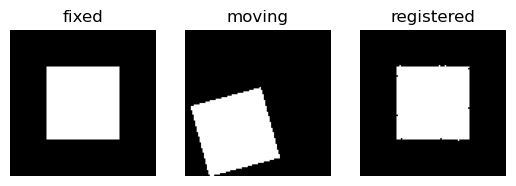

In [8]:
show_images([fixed_image, moving_image, unconstrained_result_image])

### Registration 2: Constrained

We will contrain the registration by setting an arbitarily high value for the `Scales` entry that corresponds to the transformation parameter (e.g. translation direction) that we want to penalize.

NOTE: To do that we need to set manually also the rest of the `Scales` values. We can find the suitable values by first doing a 'dry-run' registration where `AutomaticScalesEstimation` is `true` and `MaximumNumberOfIterations` is `1`. We then find the calculated `Scales` by inspecting the log.

Following the above-mentioned procdure we see that the calculated `Scales` are `[1666.5, 1, 1]`. Now, let's penalize one of the entries.

In [9]:
constrained_rigid_parameter_object = itk.ParameterObject.New()
constrained_rigid_parameter_map = constrained_rigid_parameter_object.GetDefaultParameterMap('rigid')
constrained_rigid_parameter_map['FinalBSplineInterpolationOrder'] = ('0')
constrained_rigid_parameter_map['AutomaticScalesEstimation'] = ('false',)
constrained_rigid_parameter_map['Scales'] = ('1666.5', '1', str(np.finfo(fixed_image.dtype).max))
constrained_rigid_parameter_object.AddParameterMap(constrained_rigid_parameter_map)

print(constrained_rigid_parameter_object)

ParameterObject (00000230A4E7EAC0)
  RTTI typeinfo:   class elastix::ParameterObject
  Reference Count: 1
  Modified Time: 35387
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (AutomaticParameterEstimation "true")
  (AutomaticScalesEstimation "false")
  (CheckNumberOfSamples "true")
  (DefaultPixelValue 0)
  (FinalBSplineInterpolationOrder 0)
  (FixedImagePyramid "FixedSmoothingImagePyramid")
  (ImageSampler "RandomCoordinate")
  (Interpolator "LinearInterpolator")
  (MaximumNumberOfIterations 256)
  (MaximumNumberOfSamplingAttempts 8)
  (Metric "AdvancedMattesMutualInformation")
  (MovingImagePyramid "MovingSmoothingImagePyramid")
  (NewSamplesEveryIteration "true")
  (NumberOfResolutions 4)
  (NumberOfSamplesForExactGradient 4096)
  (NumberOfSpatialSamples 2048)
  (Optimizer "AdaptiveStochasticGradientDescent")
  (Registration "MultiResolutionRegistration")
  (ResampleInterpolator "FinalBSplineInterpolator")
  (Resampler "DefaultResampler")
  (ResultImageForma

In [10]:
constrained_result_image, result_transform_parameters = itk.elastix_registration_method(
    fixed_image, moving_image,
    parameter_object=constrained_rigid_parameter_object,
    log_to_console=False)

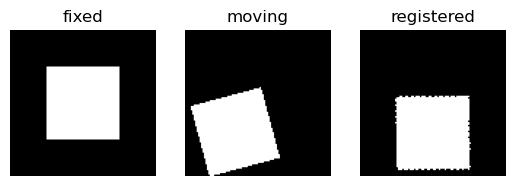

In [11]:
show_images([fixed_image, moving_image, constrained_result_image])